In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
lightcurves = pd.read_pickle('data/lightcurves.pickle')

In [3]:
# objects in the data
lightcurves.SIM_MODEL_NAME

7649467     SIMSED.SNIax                    
7207396     SIMSED.SNIbc-MOSFIT             
26401371    SALT2.WFIRST-H17                
1414696     SIMSED.SNIa-91bg                
8285291     SIMSED.SNIbc-MOSFIT             
4710933     SIMSED.SNIa-91bg                
599266      SIMSED.SNIbc-MOSFIT             
37096172    SIMSED.TDE-MOSFIT               
25066907    SIMSED.SNIax                    
939         SIMSED.BULLA-BNS-M2-2COMP       
Name: SIM_MODEL_NAME, dtype: object

# Plot the KN

In [4]:
kn = lightcurves.iloc[-1]  # the last one is the KN

Text(0.5, 0, 'Time (days)')

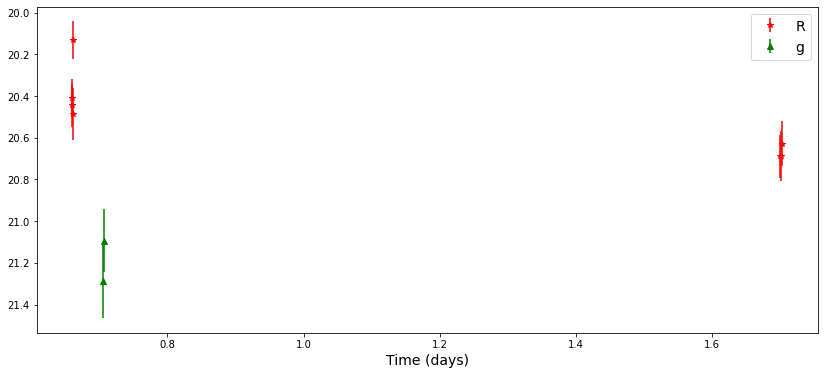

In [5]:
plt.figure(figsize=(14, 6))

pkmjd_kn = kn.pkmjd
mjd_r_kn = kn.mjd_r - pkmjd_kn
mjd_g_kn = kn.mjd_g - pkmjd_kn

plt.errorbar(mjd_r_kn, kn.mag_r, yerr=kn.magerr_r, color='red',
             marker='*', fmt='o', label='R')
plt.errorbar(mjd_g_kn, kn.mag_g, yerr=kn.magerr_g, color='green',
             marker='^', fmt='o', label='g')
plt.ylim(plt.ylim()[::-1])
plt.legend(fontsize=14)
plt.xlabel('Time (days)', fontsize=14)

# Plot a few other objects

Text(0.5, 0, 'Time (days)')

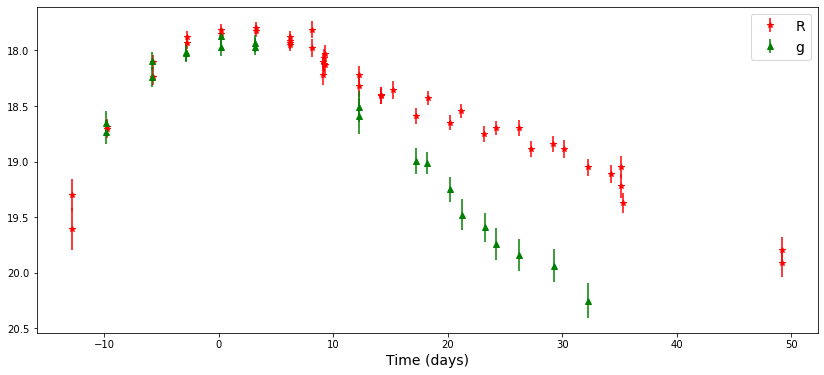

In [6]:
plt.figure(figsize=(14, 6))

for idx, row in lightcurves.iterrows():
    if 'SALT' not in row.SIM_MODEL_NAME:  # plot SALT2 Ia; try a few others from list above
        continue
    pkmjd = row.pkmjd
    mjd_r = row.mjd_r - pkmjd
    mjd_g = row.mjd_g - pkmjd
    plt.errorbar(mjd_r, row.mag_r, yerr=row.magerr_r, color='red',
             marker='*', fmt='o', label='R')
    plt.errorbar(mjd_g, row.mag_g, yerr=row.magerr_g, color='green',
             marker='^', fmt='o', label='g')
plt.ylim(plt.ylim()[::-1])
plt.legend(fontsize=14)
plt.xlabel('Time (days)', fontsize=14)

# Associated skymap

In [7]:
import healpy as hp
from ligo.skymap.io import read_sky_map

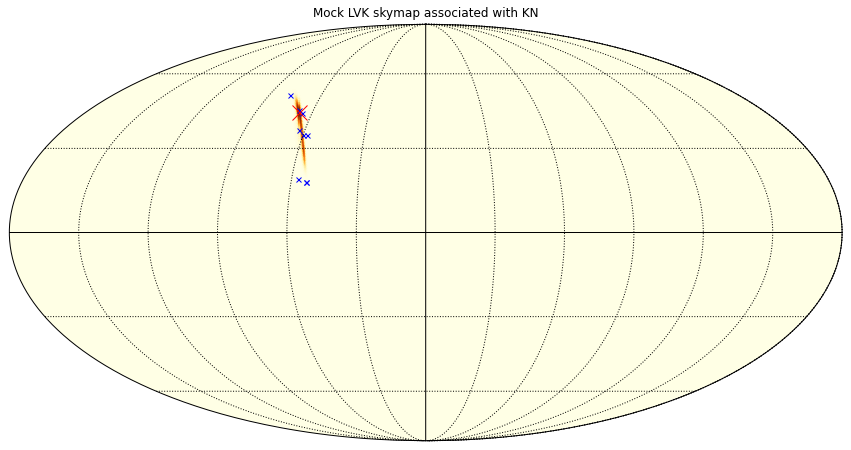

In [8]:
skymap, *h = read_sky_map('data/skymap.fits')
plt.figure(figsize=(15, 10))
hp.mollview(skymap, fig=0, cmap='YlOrBr', cbar=False, hold=True,
            title="Mock LVK skymap associated with KN")

# plot locations of all objects
for idx, row in lightcurves.iterrows():
    hp.visufunc.projplot(
        row.SIM_RA, row.SIM_DEC, lonlat=True, marker='x',
        c='r' if row.true_label else 'b',
        markersize=15 if row.true_label else 5
    )
hp.graticule()